
For the course project from [Supervised Machine Learning: Regression](https://www.coursera.org/learn/supervised-machine-learning-regression), I choose to work with Kaggle dataset [Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance).
 
The main objective of the analysys is use Linear Regression to predict the amount spend on medical insurance give some characteristics from the contractor and discuss which factors contribute to a higher or lower spend on insurance.

The dataset is composed by 7 features (including the target) which are:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight.

- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance



# 1. Import packages

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from scipy.stats import ttest_ind

# 2. Exploratory Data Analysis

In [10]:
PATH = "../data/"

In [12]:
#load from csv file
df_raw = pd.read_csv(PATH+"insurance.csv")

#making a copy to previne changes on the oriinal dataset
df = df_raw.copy()

In [5]:
#check the 5 firts rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#check the 5 latests rows
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [ ]:
#checking for dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
#descriptive statistics
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207,14.050,18.000,27.000,39.000,51.000,64.000
bmi,1338.0,30.663,6.098,15.960,26.296,30.400,34.694,53.130
children,1338.0,1.095,1.205,0.000,0.000,1.000,2.000,5.000
charges,1338.0,13270.422,12110.011,1121.874,4740.287,9382.033,16639.913,63770.428


- Pandas inferred correctly the type of features.
- There is no missing value
- Data are in different scales, we should consider scale this dataset since we are interested in the model coeficients for interpretability. 
- Charges seems to be some outliers becase the high distance between 75% percentile and max value.

## Univariate Analysys

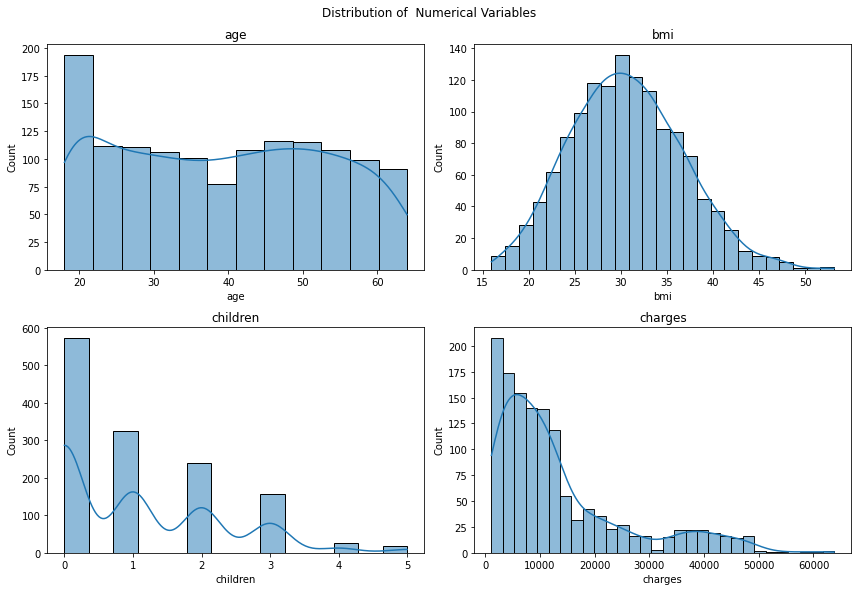

In [10]:
#####check distribution for numerical variables

#select only numerical features
numerical = df.select_dtypes(include = np.number).columns.to_list()

#making the figure
fig, ax = plt.subplots(2,2, figsize = (12,8))

#ploting the axis
for idx, var in enumerate(numerical):
  sns.histplot(data = df, x = var, kde = True, ax = ax.flat[idx])
  ax.flat[idx].set_title(var)

#title and spacing
fig.suptitle("Distribution of  Numerical Variables", y = 1.02)
fig.tight_layout(pad = 1)

- Age have a uniform distribution except for the peak in 20 years.

- bmi has a normal pattern centered around 30. This is a alarmant information because a bmi of 30 means obesity and the majority of the sample are in this situation. 

- Charges seems to be log-normal distrbuted with a very long right tail. It's a typical renue pattern, much people spend few (in this case from 0 to 10.00) and few people spend a lot (> 10k). We can try some transformations on that to let it more normal.



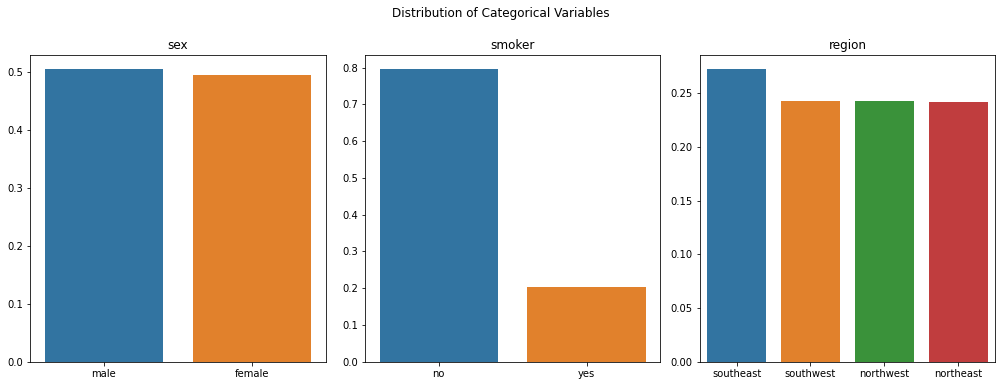

In [12]:
#####Check distribution for categorical features

#select only numerical features
categorical = df.select_dtypes(include = 'object').columns.to_list()

#making the figure
fig, ax = plt.subplots(1,3, figsize = (14,5))

#ploting the axis
for idx, var in enumerate(categorical):
  count = df[var].value_counts(normalize = True)
  sns.barplot(x = count.index, y=count.values, ax = ax.flat[idx])
  ax.flat[idx].set_title(var)

#title and spacing
fig.suptitle("Distribution of Categorical Variables", y = 1.06)
fig.tight_layout(pad = 1)

-  Sex are prety well balanced.
- No smoker are the majority class (more than 80% of observtions).
- Region are balanced but southeast region have a little more observations than others.


## Multivariate Analysys

In [ ]:
#Correlation Matrix

corr = df.corr()
round(corr, 2)

,age,bmi,children,charges
age,1.00,0.11,0.04,0.30
bmi,0.11,1.00,0.01,0.20
children,0.04,0.01,1.00,0.07
charges,0.30,0.20,0.07,1.00


- We can see a small positive correlation between charges vs age (0.30) and charges vs bmi (0.20)
- There are no multicolinearity between features

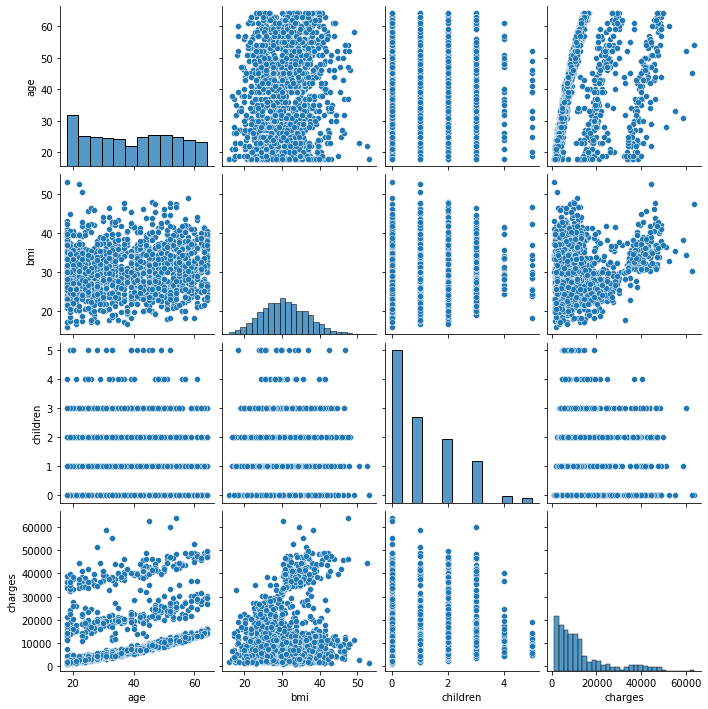

In [13]:
#Let's try view this correlations on pairplot
sns.pairplot(df);

- There's difficult to see any relevant relationship from pairplot

## Dealing with Outliers

In [14]:
# check for outilers
def get_outliers(df, feature, text_output = "No"):
  """ Function witch return observations outside lower and upper interval for a sngle feature 
  calculated based on IQR"""
  n = df.shape[0]
  q1, q3 = np.quantile(df[feature], 0.25), np.quantile(df[feature], 0.75) 
  IQR = q3 - q1
  lower, upper = q1 - IQR*1.5, q3 + IQR*1.5
  outliers = df[feature][(df[feature] > upper) | (df[feature] < lower)]

  if text_output == "Yes":
    print(f'{feature}: {len(outliers)} Outliers ({((len(outliers)/n)*100):.2f}% from total observations)\n')
  return outliers

In [15]:
# We already know that charges is log normal, let's log transformation to see the impact on outliers
df["log_charges"] = np.log(df.charges.values)

In [16]:
#applying the function
for i in numerical + ["log_charges"]:
  get_outliers(df, i, text_output = "Yes")

age: 0 Outliers (0.00% from total observations)

bmi: 9 Outliers (0.67% from total observations)

children: 0 Outliers (0.00% from total observations)

charges: 139 Outliers (10.39% from total observations)

log_charges: 0 Outliers (0.00% from total observations)



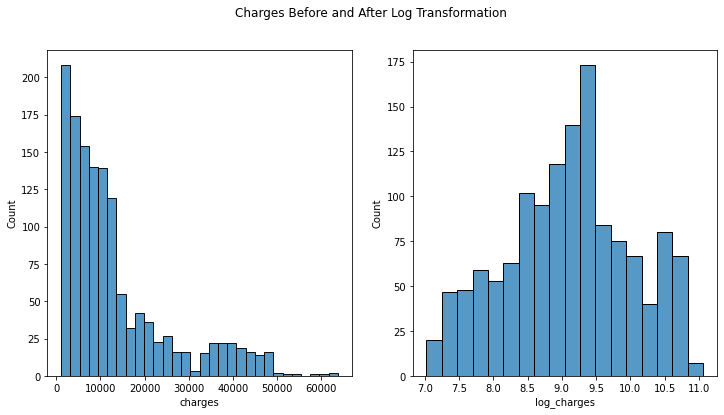

In [19]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
sns.histplot(data = df, x = "charges", ax = ax[0])
sns.histplot(data = df, x = "log_charges", ax = ax[1])
fig.suptitle('Charges Before and After Log Transformation');

- We have a signifficant amount of outliers in charges features (10% from all observations).
- Log transformation do a great job limiting outliers and giving a more normal shape to charges. Let's leave this information to the modeling stage.

## Creating Hypotesis From Data

Let's make some assumptions to help us to drive the exploratory data analysis and try to validate them with the data. 

- H1: People with poor physical conditioning (high bmi) spend more on insurance. Maybe because they are more worried about helth.
- H2: Same for smoke habit.
- H3: There is a relationship between smoke and high bmi index. Maybe most of the smokers have high bmi index or most of the people with high bmi index are smoker. 
- H4: Have more children lead to more spends on insurace. Maybe because have a lot of children could be associated to a beter financial condition.
- H5: Youngers spend minus than olders

### H1: People with poor physical conditioning (high bmi) spend more on insurance.

Before start, let's discretize bmi in groups following the [CDC classification](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html):
- below 18.5 - underweight
-  18.5 – 24.9 - healthy
- 25.0 – 29.9 - overweight
- 30.0 and Above - obesity 

In [20]:
#create new categories for bmi
df["bmi_cat"] = pd.cut(df.bmi, bins = [-np.inf, 18.5, 24.9, 29.9, np.inf], labels = ["underweight", "healthy", "overweight","obesity"])

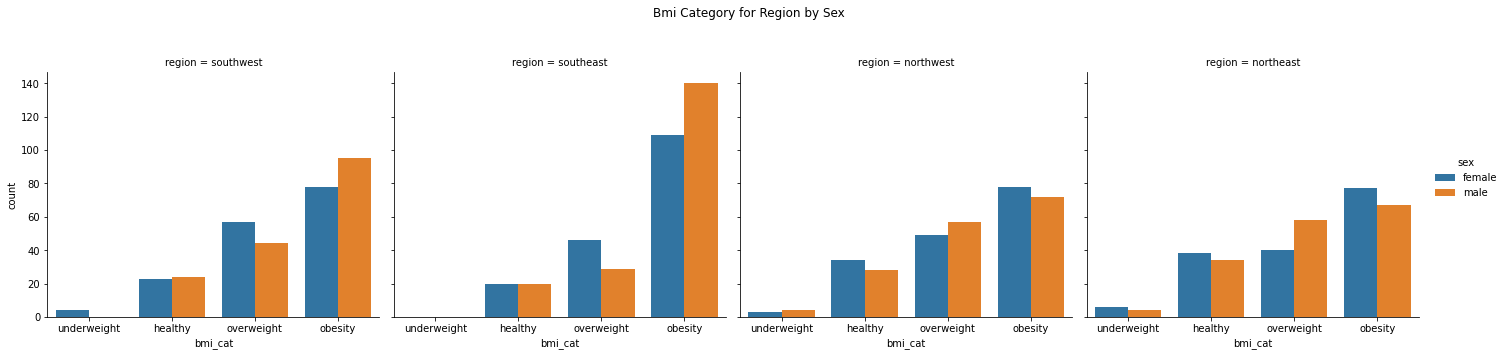

In [21]:
rp = sns.catplot(data = df, x = "bmi_cat", kind = "count", hue = "sex", col = "region")
rp.fig.subplots_adjust(top=0.8);
rp.fig.suptitle("Bmi Category for Region by Sex");

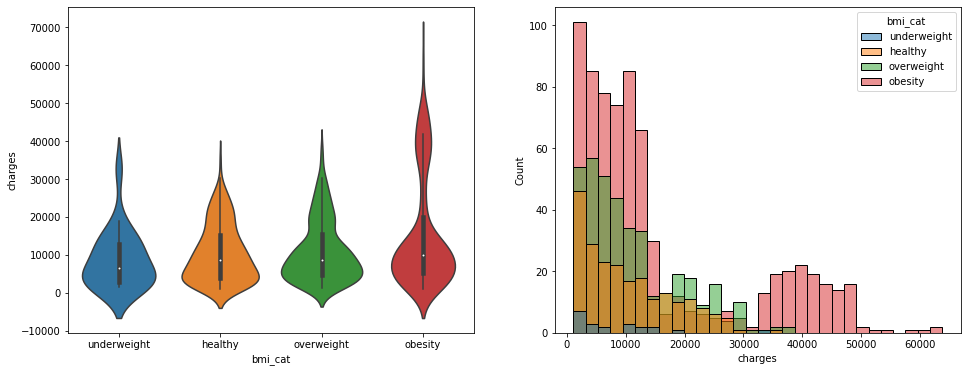

In [22]:
fig, ax = plt.subplots(1,2,figsize = (16,6))
sns.violinplot(data = df, x = "bmi_cat", y = "charges", ax = ax[0])
sns.histplot(data = df, hue = "bmi_cat", x = "charges", ax = ax[1]);

- Obesity (bmi > 29.9) prevails over other bmi categories in all the regions.
- Southeast is the region with the major number of obese.
- Female tends to be more obese in north and male in south
- Obesity dominates charges right tail and had more outliers than others groups. This mean that obesity group spend more higher values than others.

We can cloncluse that obesity group spend higher values with insurance more than any other group.

### H2: Smokers spend more on insurance than no smokers.

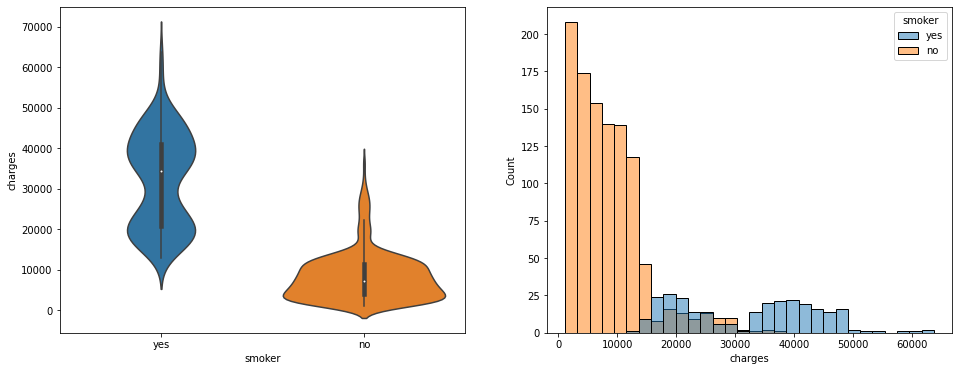

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,6))
sns.violinplot(data = df, x = "smoker", y = "charges", ax = ax[0])
sns.histplot(data = df, hue = "smoker", x = "charges", ax = ax[1]);

In [30]:
sample1 = df[df["smoker"] == "yes"]["charges"].values
sample2 = df[df["smoker"] == "no"]["charges"].values

In [28]:
(abs(np.mean(sample1) - np.mean(sample2)) / np.mean(sample2)) * 100.0

282.6360242449624

In [29]:
stat, p = ttest_ind(a = sample1, b = sample2)
p

6.697539492604112e-120

The difference between smoker and non smoker are huge. Smokers spend on average 280% more than no smokers. This reflects on the very small p-value (<0.05) which mean we can reject the null hypothesys and assume the samples means are significally differentes.

### H3: There is a relationship between smoke and high bmi index.

In [ ]:
count = df.groupby("bmi_cat")["smoker"].value_counts(normalize = True)
count.name = ""
count = count.reset_index()
count = count.rename(columns = {"":"prop"})

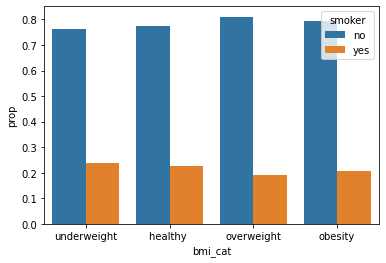

In [ ]:
sns.barplot(data = count, x = "bmi_cat", y = "prop", hue = "smoker");

Around 20% from the obesity smokes. This proportion don't vary between others groups. Smoke don't seem to be related to obesity

### H4: Have more children lead to more spends on insurace.

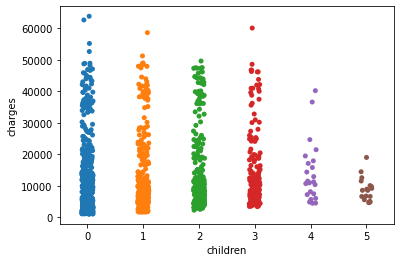

In [ ]:
sns.stripplot(data=df, x="children", y="charges");

Increase children numbers don't seem to be related to higher charges as we can see for 4 and 5 children.

### H5: Youngers spend minus than olders

In [ ]:
df.age.sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [ ]:
#create bins simillar to was done on bmi
df["age_cat"] = pd.cut(df.age, [17,35,60,np.inf], labels = ["young_adult","middle","senior"])

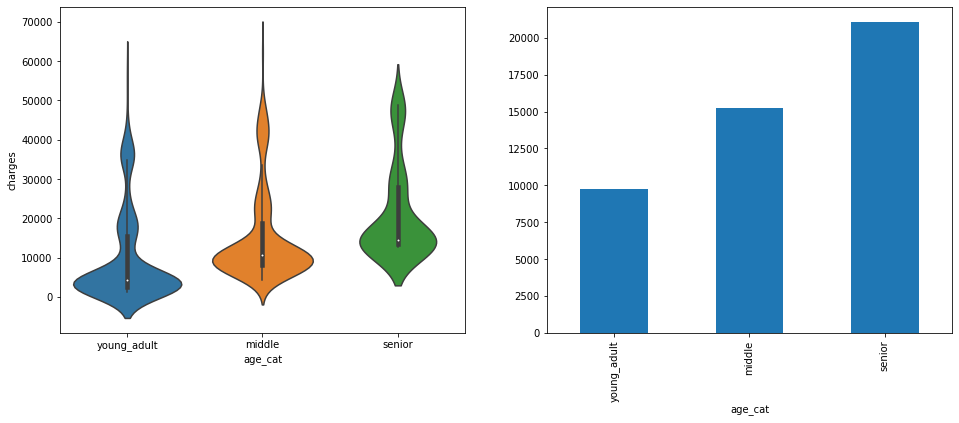

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,6))
sns.violinplot(data = df, x = "age_cat", y = "charges", ax = ax[0])
df.groupby("age_cat").mean()["charges"].plot(kind = "bar", ax = ax[1]);

The charges median and mean from senior group are superior than middle 

# Machine Learning

## Encoding Categorical Features

In [47]:
#reload df
df = df_raw.copy()

In [48]:
#one hot encoding
sex_enc = pd.get_dummies(df.sex, drop_first = True)
smoker_enc = pd.get_dummies(df.smoker, drop_first = True)
region_enc = pd.get_dummies(df.region, drop_first = True)

In [49]:
#applying encoder on dataframe
df = df.drop(["sex","smoker","region"], axis = 1)
df = pd.concat([df, sex_enc, smoker_enc, region_enc], axis = 1)
df = df.rename(columns = {"yes":"smoker"})
df.head()

,age,bmi,children,charges,male,smoker,northwest,southeast,southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Train and Test Separation

In [50]:
#isolate target from features
X = df.drop("charges", axis = 1)
y = df["charges"]

#train test split
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

## Model Selection With Cross Validation

In [51]:
cv = KFold(n_splits = 4, shuffle = True, random_state = 42)

In [52]:
#baseline - Linear Rgression with StandardScaler

pipe = make_pipeline(StandardScaler(), LinearRegression())
baseline = cross_val_score(pipe, X_train, y_train, scoring= "neg_root_mean_squared_error", cv = cv, n_jobs = -1)
abs(np.mean(baseline)), np.std(baseline)

(6216.574884424126, 334.4886077953323)

In [53]:
#we need to fit the pipeline outside cross val score to acess the coefs
pipe.fit(X_train, y_train)

coefs = pipe[1].coef_
intercept = pipe[1].intercept_

coefs

array([3688.58318998, 2090.99783407,  514.02360356,   52.38868121,
       9595.8681675 , -209.32555139, -426.26277109, -394.01444936])

In [ ]:
#Linear Regression with StandardScaler and Target log tranformed
pipe = make_pipeline(StandardScaler(), LinearRegression())
tt =TransformedTargetRegressor(pipe,func=np.log1p, inverse_func=np.expm1)
baseline = cross_val_score(tt, X_train, y_train, scoring= "neg_root_mean_squared_error", cv = cv, n_jobs = -1)
abs(np.mean(baseline)), np.std(baseline)

(8687.101150727029, 645.8625815817983)

Target tranformation make the model worse than baseline

In [ ]:
#Lasso Regression - Chose Best alpha with cross validation (4 folds)
alphas = np.linspace(0.001, 200, 20)
lower_score, best_alpha = 100000000, 0
for alpha in alphas:
  pipe = make_pipeline(StandardScaler(), Lasso(alpha = alpha, random_state = 42))
  cv_score = cross_val_score(pipe, X_train, y_train, scoring= "neg_root_mean_squared_error", cv = cv, n_jobs = -1)

  if abs(np.mean(cv_score)) < lower_score:
    lower_score = abs(np.mean(cv_score))
    best_alpha = alpha

  print(f"alpha = {alpha:.3f} | RMSE: {abs(np.mean(cv_score)):.3f} ± {abs(np.std(cv_score)):.3f}") 

print("_"*40)
print(f"Best alpha: {best_alpha:.3f} - RMSE: {lower_score:.3f}")


alpha = 0.001 | RMSE: 6216.575 ± 334.489
alpha = 10.527 | RMSE: 6215.654 ± 337.503
alpha = 21.054 | RMSE: 6214.752 ± 340.228
alpha = 31.580 | RMSE: 6214.122 ± 342.901
alpha = 42.106 | RMSE: 6213.695 ± 345.582
alpha = 52.632 | RMSE: 6213.503 ± 348.257
alpha = 63.159 | RMSE: 6213.678 ± 350.863
alpha = 73.685 | RMSE: 6213.416 ± 352.849
alpha = 84.211 | RMSE: 6212.790 ± 354.373
alpha = 94.737 | RMSE: 6212.055 ± 355.612
alpha = 105.264 | RMSE: 6211.516 ± 356.782
alpha = 115.790 | RMSE: 6211.151 ± 357.868
alpha = 126.316 | RMSE: 6211.067 ± 358.657
alpha = 136.842 | RMSE: 6211.156 ± 359.322
alpha = 147.369 | RMSE: 6211.359 ± 359.959
alpha = 157.895 | RMSE: 6211.676 ± 360.569
alpha = 168.421 | RMSE: 6212.108 ± 361.152
alpha = 178.947 | RMSE: 6212.648 ± 361.706
alpha = 189.474 | RMSE: 6213.208 ± 362.182
alpha = 200.000 | RMSE: 6213.876 ± 362.628
________________________________________
Best alpha: 126.316 - RMSE: 6211.067


Lasso (RMSE: 6211.067) promoted a insignificant improvement from the baseline (RMSE: 6216.5748).

In [55]:
#fitting lasso to get the coefs
pipe = make_pipeline(StandardScaler(), Lasso(alpha = 126.316, random_state = 42))
pipe.fit(X_train, y_train)

coefs_reg = pipe[1].coef_
intercept_reg = pipe[1].intercept_

In [58]:
# Comparing unregularized coefs vs regularized coefs
coef_df = pd.DataFrame({"features": X_train.columns,
              "Unreg Coefs": coefs,
             "Reg Coefs": coefs_reg})
coef_df.loc[len(coef_df)] = ["intercept", intercept, intercept_reg]
coef_df = coef_df.sort_values(by = "Reg Coefs", ascending = False)

coef_df

,features,Unreg Coefs,Reg Coefs
8,intercept,13379.157307,13379.157307
4,smoker,9595.868167,9467.736853
0,age,3688.583190,3581.127388
1,bmi,2090.997834,1905.990438
2,children,514.023604,405.048818
3,male,52.388681,0.000000
5,northwest,-209.325551,-0.000000
6,southeast,-426.262771,-82.231648
7,southwest,-394.014449,-85.134280


Here we can see the regularization in action: Lasso make the male coef to 0, indicating that sex is not relevant for prediction. Also the regularizated coefs are lower than unregularized, this is due to Lasso's attempt to reduce the complexity of the model.

In accordance with the findings in EDA analysys, smoker, age and bmi are relevant features to the models according her coefs. For example, each year is related to a increase of 3688 in charges keeping all others features constant and a smoker spend in average 9595 more than no smokers, again keeping others features constant.   

In [ ]:
#polynomial regression (degree 2) with lasso regularization with cross validation to choose alhpa

alphas = np.linspace(0.001, 200, 20)
lower_score, best_alpha = 100000000, 0
for alpha in alphas:
  pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias = False),
                     StandardScaler(),
                     Lasso(alpha = alpha, random_state = 42))
  cv_score = cross_val_score(pipe, X_train, y_train, scoring= "neg_root_mean_squared_error", cv = cv, n_jobs = -1)

  if abs(np.mean(cv_score)) < lower_score:
    lower_score = abs(np.mean(cv_score))
    best_alpha = alpha

  print(f"alpha = {alpha:.3f} | RMSE: {abs(np.mean(cv_score)):.3f} ± {abs(np.std(cv_score)):.3f}") 

print("_"*40)
print(f"Best alpha: {best_alpha:.3f} - RMSE: {lower_score:.3f}")

alpha = 0.001 | RMSE: 5034.758 ± 480.422
alpha = 10.527 | RMSE: 5009.390 ± 466.482
alpha = 21.054 | RMSE: 5001.815 ± 451.530
alpha = 31.580 | RMSE: 5003.598 ± 444.600
alpha = 42.106 | RMSE: 5009.108 ± 445.219
alpha = 52.632 | RMSE: 5016.348 ± 446.117
alpha = 63.159 | RMSE: 5025.669 ± 445.483
alpha = 73.685 | RMSE: 5036.753 ± 443.915
alpha = 84.211 | RMSE: 5049.576 ± 440.361
alpha = 94.737 | RMSE: 5065.196 ± 436.611
alpha = 105.264 | RMSE: 5083.547 ± 433.208
alpha = 115.790 | RMSE: 5105.162 ± 430.022
alpha = 126.316 | RMSE: 5129.662 ± 426.662
alpha = 136.842 | RMSE: 5157.316 ± 423.112
alpha = 147.369 | RMSE: 5187.270 ± 419.204
alpha = 157.895 | RMSE: 5206.195 ± 425.047
alpha = 168.421 | RMSE: 5219.756 ± 435.787
alpha = 178.947 | RMSE: 5228.913 ± 439.410
alpha = 189.474 | RMSE: 5235.137 ± 442.592
alpha = 200.000 | RMSE: 5238.997 ± 445.333
________________________________________
Best alpha: 21.054 - RMSE: 5001.815


Now with Polynomial Regression Regularized (RMSE: 5001) we have a significant improvement from the baseline (RMSE: 6216.5748).

In [ ]:
cv_scores = [6216.574884424126, 8687.101150727029, 6211.067, 5001.815]
rotules = ["Baseline (Linear Reg)", "Linear Reg + Target Transf", "Lasso Regression", "Polynomial Reg + Lasso"]

pd.DataFrame({"Model": rotules,
              "RMSE(Cross Val)": cv_scores})

,Model,RMSE(Cross Val)
0,Baseline (Linear Reg),6216.574884
1,Linear Reg + Target Transf,8687.101151
2,Lasso Regression,6211.067000
3,Polynomial Reg + Lasso,5001.815000


Because Polynomial Regression with Lasso reached the lowest RMSE score in the same cross validation strategy as the others, i'ts the final version from model.

In [ ]:
#final avaliation on test
best_pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias = False),StandardScaler(), Lasso(alpha = 21.054, random_state = 42))
best_pipe.fit(X_train, y_train)

yhat = best_pipe.predict(X_test)

np.sqrt(mean_squared_error(y_test, yhat))

4511.7690065103725